# **Hava Durumu ve Mevsimsel Salgın İlişkisi Analizi ve Tahmini**

## **Problem Tanımı**
Mevsimsel hastalıkların takibi genellikle sağlık kuruluşlarından toplanan ve gecikmeli gelen verilere dayanmaktadır. Halk sağlığını korumak adına, salgın eğilimlerini gerçek zamanlı olarak öngörebilen proaktif sistemlere ihtiyaç duyulmaktadır.

## **Amaç**
Bu proje, halka açık Google Trends ve hava durumu verilerini kullanarak bir erken uyarı sistemi prototipi geliştirmeyi amaçlamaktadır. Proje kapsamında, son 5 yıllık verilerle hava sıcaklığındaki değişimler ile "grip", "ateş" gibi anahtar kelimelerin aranma hacimleri arasındaki ilişki zaman serisi analizi ile modellenecek ve bu model aracılığıyla önümüzdeki haftalara yönelik potansiyel salgın riski tahmin edilecektir.

## **Proje Akışı ve Metodoloji**

Bu proje, bir veri bilimi projesinin baştan sona tüm yaşam döngüsünü kapsamaktadır. İzlenen adımlar aşağıda özetlenmiştir:

**1. Veri Toplama ve Birleştirme (Data Collection & Integration)**
Google Trends Verisi: Son 5 yıllık periyot için belirlenen anahtar kelimelerin ('grip', 'öksürük', vb.) haftalık arama hacimleri, Google Trends web sitesinden .csv formatında manuel olarak indirilmiştir.

Hava Durumu Verisi: Open-Meteo API'si aracılığıyla, aynı zaman aralığı için Ankara lokasyonuna ait günlük ortalama sıcaklık ve toplam yağış verileri çekilmiştir.

Birleştirme: İki farklı veri kaynağı, ortak bir zaman dizini üzerinde (haftalık bazda) tek bir ana veri setinde birleştirilmiştir.

**2. Veri Temizleme ve Ön İşleme (Data Cleaning & Preprocessing)**

Veri kaynaklarının başlangıç tarihlerindeki uyuşmazlık nedeniyle oluşan eksik verili ilk satır, veri setinden çıkarılarak zamanla hizalama sağlanmıştır.

Sütun adları standartlaştırılmış ve tüm veri tipleri (özellikle tarih ve sayısal değerler) analiz için uygun formatlara dönüştürülmüştür.

**3. Keşifsel Veri Analizi (EDA) ve Hipotez Testi**

Arama trendleri ve hava durumu metrikleri arasındaki ilişkiyi ölçmek için korelasyon analizi ve ısı haritası (heatmap) kullanılmıştır.

Hastalıkların ortaya çıkma süresi olabileceği hipotezine dayalı olarak, gecikmeli (lagged) sıcaklık verisinin etkisi test edilmiş, ancak güncel haftanın sıcaklığının daha güçlü bir sinyal olduğu keşfedilmiştir.

İlişkilerin zaman içindeki döngüsünü görmek için zaman serisi grafikleri çizilmiştir.

**4. Özellik Mühendisliği (Feature Engineering)**

Problem, bir regresyon probleminden sınıflandırma problemine dönüştürülmüştür.

'Öksürük' arama verisinin ortalaması ve standart sapması kullanılarak istatistiksel bir eşik değeri belirlenmiş ve haftalar 'Salgın Var (1)' veya 'Salgın Yok (0)' olarak etiketlenerek salgin_durumu adlı hedef değişken oluşturulmuştur.

Modelin geleceği tahmin edebilmesi için hedef değişken bir hafta öne kaydırılmış (shift(-1)) ve modele bağlam katmak için gecikmeli özellikler (lag features) eklenmiştir.

**5. Sınıflandırma Modelinin Geliştirilmesi ve Değerlendirilmesi**

Gelecek haftanın "salgın riski" olup olmayacağını tahmin etmek için bir Lojistik Regresyon modeli kurulmuştur.

Veri seti, modelin performansını objektif bir şekilde ölçmek için eğitim (%70) ve test (%30) olarak ikiye ayrılmıştır.

Modelin performansı, Karmaşıklık Matrisi (Confusion Matrix), Precision (Kesinlik), Recall (Duyarlılık) ve F1-Skoru gibi sınıflandırma metrikleri ile değerlendirilmiştir.

**6. Sonuçların Yorumlanması**

Elde edilen model performans raporu yorumlanarak, prototipin bir erken uyarı sistemi olarak potansiyeli ve başarı oranları analiz edilmiştir.

### Gerekli Kütüphane Kurulumu

Google Trends verilerini çekebilmek için `pytrends` kütüphanesi yüklenmektedir.

In [113]:
pip install pytrends

### Proje İçin Gerekli Kütüphanelerin Yüklenmesi

In [114]:

# Veri işleme ve analizi için
import pandas as pd
import requests

# Görselleştirme için
import seaborn as sns
import matplotlib.pyplot as plt

# Makine öğrenmesi modeli için
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

print("Tüm kütüphaneler başarıyla yüklendi.")

Tüm kütüphaneler başarıyla yüklendi.


In [115]:
# Google'a Türkiye'den bağlandığımızı belirtiyoruz
pytrends = TrendReq(hl='tr-TR', tz=360)

# Daha önce belirlediğimiz anahtar kelimelerimiz
anahtar_kelimeler = ['grip', 'nezle', 'öksürük', 'ateş', 'boğaz ağrısı']

In [116]:
# Veri çekmek için gerekli ayarları yapıyoruz
# timeframe: 'YYYY-AA-GG YYYY-AA-GG' formatında son 5 yılı belirtiyoruz
# geo: 'TR' ile Türkiye'yi seçiyoruz
pytrends.build_payload(
    kw_list=anahtar_kelimeler,
    cat=0,
    timeframe='2020-10-14 2025-10-14', # Son 5 yıl
    geo='TR'
)

In [117]:
# Google Trends'ten indirilen CSV dosyasını okuyoruz (ilk satır başlık bilgisi içerdiğinden atlanıyor)
dosya_adi = 'multiTimeline.csv'
df = pd.read_csv(dosya_adi, skiprows=1)

In [118]:
print(df.head())

        Hafta  grip: (Türkiye) nezle: (Türkiye)  öksürük: (Türkiye)  \
0  2020-10-11                8                1                   4   
1  2020-10-18               28                1                   5   
2  2020-10-25               14                1                   7   
3  2020-11-01               11                2                   7   
4  2020-11-08               10                2                   8   

   ateş: (Türkiye)  boğaz ağrısı: (Türkiye)  
0               42                        3  
1               43                        3  
2               41                        3  
3               40                        3  
4               44                        3  


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Hafta                    262 non-null    object
 1   grip: (Türkiye)          262 non-null    int64 
 2   nezle: (Türkiye)         262 non-null    object
 3   öksürük: (Türkiye)       262 non-null    int64 
 4   ateş: (Türkiye)          262 non-null    int64 
 5   boğaz ağrısı: (Türkiye)  262 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 12.4+ KB


In [120]:
#VERİYİ TEMİZLEME VE DÜZENLEME
# Sütun isimlerini belirliyoruz
df.columns = ['Hafta', 'grip', 'nezle', 'öksürük', 'ates', 'bogaz_agrisi']

In [121]:
# 'Hafta' sütununu datetime formatına dönüştürüyoruz
df['Hafta'] = pd.to_datetime(df['Hafta'])
df.head()

,Hafta,grip,nezle,öksürük,ates,bogaz_agrisi
0,2020-10-11,8,1,4,42,3
1,2020-10-18,28,1,5,43,3
2,2020-10-25,14,1,7,41,3
3,2020-11-01,11,2,7,40,3
4,2020-11-08,10,2,8,44,3


In [122]:
# '<1' şeklinde gösterilen çok düşük arama değerlerini 0 ile değiştiriyoruz
# Ardından her sütunu sayısal (int) veri tipine dönüştürüyoruz
for sutun in ['grip', 'nezle', 'öksürük', 'ates', 'bogaz_agrisi']:
    df[sutun] = df[sutun].replace('<1', '0')
    df[sutun] = pd.to_numeric(df[sutun])

In [123]:
# 'Hafta' sütununu indeks olarak ayarlıyoruz
df.set_index('Hafta', inplace=True)


In [124]:
df.head()

,grip,nezle,öksürük,ates,bogaz_agrisi
Hafta,,,,,
2020-10-11,8,1,4,42,3
2020-10-18,28,1,5,43,3
2020-10-25,14,1,7,41,3
2020-11-01,11,2,7,40,3
2020-11-08,10,2,8,44,3


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-10-11 to 2025-10-12
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   grip          262 non-null    int64
 1   nezle         262 non-null    int64
 2   öksürük       262 non-null    int64
 3   ates          262 non-null    int64
 4   bogaz_agrisi  262 non-null    int64
dtypes: int64(5)
memory usage: 12.3 KB


### Google Trends Verisinin Yüklenmesi ve Ön İşlenmesi

Bu bölümde, projenin ana veri kaynaklarından biri olan Google Trends verisi `pandas` kütüphanesi kullanılarak bir DataFrame'e aktarılmıştır. Verinin ham hali, analiz için uygun olmadığından bir dizi ön işleme adımından geçirilmiştir:

* **Sütun Adlarının Düzenlenmesi:** Orijinal dosyadaki `'kelime: (Türkiye)'` formatındaki karmaşık sütun adları, kod içinde daha kolay erişim için basitleştirilmiştir (örn: `'öksürük'`).
* **Veri Tipi Dönüşümü:** Tarih bilgisi içeren `'Hafta'` sütunu, metin formatından `datetime` formatına dönüştürülerek zaman serisi analizleri için uygun hale getirilmiştir.
* **Sayısal Olmayan Değerlerin Temizlenmesi:** Düşük arama hacimlerini temsil eden `'<1'` gibi metin ifadeleri, sayısal `0` değerine dönüştürülmüş ve tüm arama trendi sütunları sayısal (numeric) formata getirilmiştir.
* **İndeks Ayarlanması:** Zaman serisi analizlerinde standart bir pratik olarak, `'Hafta'` sütunu veri setinin indeksi olarak atanmıştır.

Bu işlemler sonucunda, analiz ve modelleme aşamaları için temiz, yapılandırılmış ve kullanıma hazır bir zaman serisi veri seti elde edilmiştir.

Projemizin hipotezini test etmek için gereken ikinci önemli veri seti ise hava durumu verileridir. Şimdi, bu arama trendleriyle ilişkilendirmek üzere, son 5 yıllık geçmiş hava durumu verilerini çekeceğiz.

In [126]:
# Sıcaklık ve yağış isteyen URL.
url = "https://archive-api.open-meteo.com/v1/archive?latitude=39.92&longitude=32.85&start_date=2020-10-16&end_date=2025-10-16&daily=temperature_2m_mean,precipitation_sum&timezone=Europe/Istanbul"

# URL'den veriyi çekiyoruz ve JSON formatında okuyoruz
response = requests.get(url)
data = response.json()

# Gelen JSON verisinden 'daily' kısmını alıp DataFrame'e çeviriyoruz
df_weather_daily = pd.DataFrame(data['daily'])

# Tarih sütununu doğru formata çeviriyoruz
df_weather_daily['time'] = pd.to_datetime(df_weather_daily['time'])

# Tarih sütununu indeks yapıyoruz
df_weather_daily.set_index('time', inplace=True)

print("--- GÜNLÜK Hava Durumu Verisi (Sıcaklık ve Yağış) ---")
print(df_weather_daily.head())

# Günlük veriyi haftalığa çeviriyoruz
df_weather_weekly = df_weather_daily.resample('W').mean()

print("\n\n--- HAFTALIK Ortalama Hava Durumu Verisi ---")
print(df_weather_weekly.head())

--- GÜNLÜK Hava Durumu Verisi (Sıcaklık ve Yağış) ---
            temperature_2m_mean  precipitation_sum
time                                              
2020-10-16                 19.1                0.0
2020-10-17                 18.8                0.0
2020-10-18                 17.5                0.4
2020-10-19                 14.4                3.8
2020-10-20                 13.9                2.8


--- HAFTALIK Ortalama Hava Durumu Verisi ---
            temperature_2m_mean  precipitation_sum
time                                              
2020-10-18            18.466667           0.133333
2020-10-25            15.714286           0.942857
2020-11-01            13.857143           0.371429
2020-11-08             8.842857           0.228571
2020-11-15             7.385714           0.000000


In [127]:
# İki DataFrame'i indeksleri (yani tarihler) üzerinden birleştiriyoruz.
df_final = df.join(df_weather_weekly)

In [128]:
# Birleşme sırasında oluşabilecek eksik verileri (NaN) kontrol ediyoruz.
print("--- Birleşme Sonrası Eksik Veri Kontrolü ---")
print(df_final.isnull().sum())

--- Birleşme Sonrası Eksik Veri Kontrolü ---
grip                   0
nezle                  0
öksürük                0
ates                   0
bogaz_agrisi           0
temperature_2m_mean    1
precipitation_sum      1
dtype: int64


In [129]:
# df_final içinde en az bir tane eksik değer olan satırları görmek istiyoruz
eksik_verili_satirlar = df_final[df_final.isnull().any(axis=1)]

print("Eksik Veri İçeren Satırlar:")
print(eksik_verili_satirlar)

Eksik Veri İçeren Satırlar:
            grip  nezle  öksürük  ates  bogaz_agrisi  temperature_2m_mean  \
Hafta                                                                       
2020-10-11     8      1        4    42             3                  NaN   

            precipitation_sum  
Hafta                          
2020-10-11                NaN  


In [130]:
# Birleştirme sonrası, Google Trends verisinin bir hafta erken başlaması
#nedeniyle ilk satırda hava durumu verileri eksik kalmıştır. Bu nedenle,
#`.iloc[1:]` komutu ile bu eksik verili ilk satır atılarak,
#analiz için tamamen hizalanmış ve temiz bir veri seti elde edilmiştir.

df_final = df_final.iloc[1:]

In [131]:
print(df_final.isnull().sum())

grip                   0
nezle                  0
öksürük                0
ates                   0
bogaz_agrisi           0
temperature_2m_mean    0
precipitation_sum      0
dtype: int64


In [132]:
print(df_final.head())

            grip  nezle  öksürük  ates  bogaz_agrisi  temperature_2m_mean  \
Hafta                                                                       
2020-10-18    28      1        5    43             3            18.466667   
2020-10-25    14      1        7    41             3            15.714286   
2020-11-01    11      2        7    40             3            13.857143   
2020-11-08    10      2        8    44             3             8.842857   
2020-11-15    10      2        9    46             4             7.385714   

            precipitation_sum  
Hafta                          
2020-10-18           0.133333  
2020-10-25           0.942857  
2020-11-01           0.371429  
2020-11-08           0.228571  
2020-11-15           0.000000  


In [133]:
# Analiz için orijinal birleşik veri setimizden bir kopya oluşturuyoruz.
df_final_analysis = df_final.copy()

# Yağış oranının ülke içinde fazla değişiklik göstereceğini düşünerek veri setinden çıkarıyoruz.
df_final_analysis.drop('precipitation_sum', axis=1, inplace=True)
print("--- Yağış Verisi Çıkarıldıktan Sonraki Sütunlar ---")
print(df_final_analysis.columns)

# Sıcaklık verisini 1 hafta gecikmeli olacak şekilde kaydırıyoruz
df_final_analysis['temperature_lag_1week'] = df_final_analysis['temperature_2m_mean'].shift(1)

# Bu işlem ilk satırda bir boşluk (NaN) yaratacağı için o satırı temizliyoruz.
df_final_analysis.dropna(inplace=True)

print("\n--- Gecikmeli Sıcaklık Eklendikten Sonraki Veri Seti (İlk 5 Satır) ---")
print(df_final_analysis.head())

--- Yağış Verisi Çıkarıldıktan Sonraki Sütunlar ---
Index(['grip', 'nezle', 'öksürük', 'ates', 'bogaz_agrisi',
       'temperature_2m_mean'],
      dtype='object')

--- Gecikmeli Sıcaklık Eklendikten Sonraki Veri Seti (İlk 5 Satır) ---
            grip  nezle  öksürük  ates  bogaz_agrisi  temperature_2m_mean  \
Hafta                                                                       
2020-10-25    14      1        7    41             3            15.714286   
2020-11-01    11      2        7    40             3            13.857143   
2020-11-08    10      2        8    44             3             8.842857   
2020-11-15    10      2        9    46             4             7.385714   
2020-11-22    10      1        8    44             4             5.142857   

            temperature_lag_1week  
Hafta                              
2020-10-25              18.466667  
2020-11-01              15.714286  
2020-11-08              13.857143  
2020-11-15               8.842857  
2020-11-

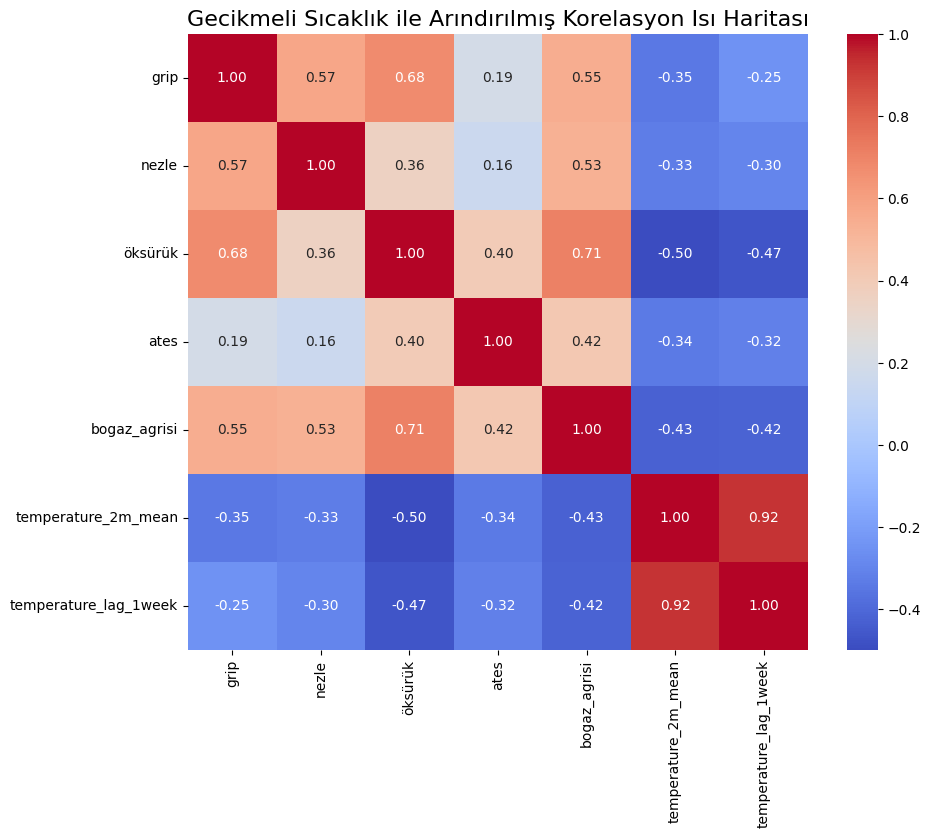

In [134]:
# Yeni veri setimizle korelasyon matrisini hesaplıyoruz
final_korelasyon_matrisi = df_final_analysis.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(final_korelasyon_matrisi, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Gecikmeli Sıcaklık ile Arındırılmış Korelasyon Isı Haritası', fontsize=16)
plt.show()

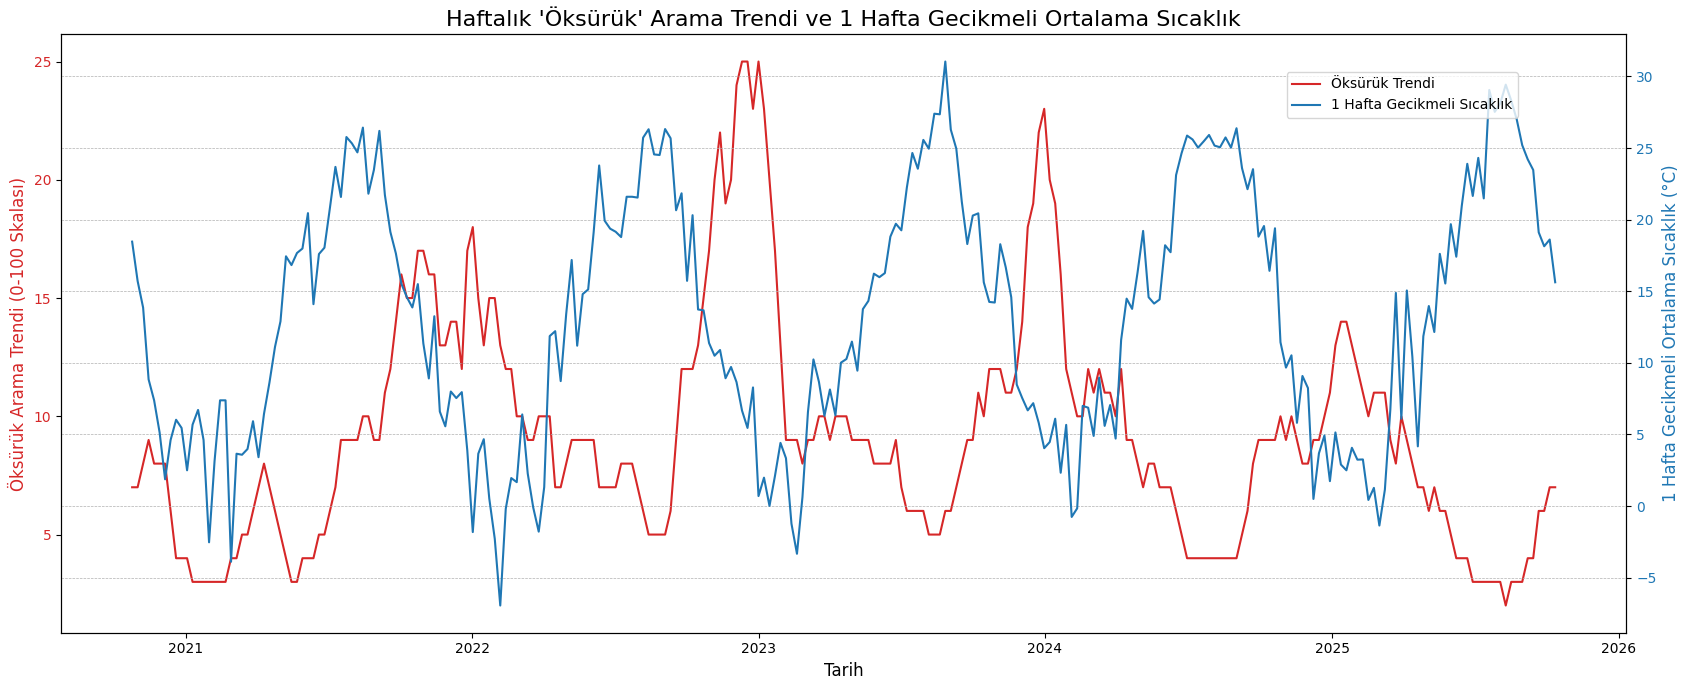

In [135]:
# Grafik boyutunu ve ana ekseni (ax1) ayarlayalım
fig, ax1 = plt.subplots(figsize=(17, 7))

# --- Sol Y Ekseni (ax1): Öksürük Verisi ---
renk1 = 'tab:red'
ax1.set_xlabel('Tarih', fontsize=12)
ax1.set_ylabel('Öksürük Arama Trendi (0-100 Skalası)', color=renk1, fontsize=12)
ax1.plot(df_final_analysis.index, df_final_analysis['öksürük'], color=renk1, label='Öksürük Trendi')
ax1.tick_params(axis='y', labelcolor=renk1)

# --- Sağ Y Ekseni (ax2): 1 HAFTA GECİKMELİ Sıcaklık Verisi ---
ax2 = ax1.twinx()
renk2 = 'tab:blue'
ax2.set_ylabel('1 Hafta Gecikmeli Ortalama Sıcaklık (°C)', color=renk2, fontsize=12)
ax2.plot(df_final_analysis.index, df_final_analysis['temperature_lag_1week'], color=renk2, label='1 Hafta Gecikmeli Sıcaklık')
ax2.tick_params(axis='y', labelcolor=renk2)


plt.title("Haftalık 'Öksürük' Arama Trendi ve 1 Hafta Gecikmeli Ortalama Sıcaklık", fontsize=16)
fig.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))

plt.show()

### Özellik Mühendisliği ve Model Kurulumu

Bu bölümde, projenin en başındaki "erken uyarı sistemi" hedefine doğrudan hizmet edecek bir makine öğrenmesi modeli kurmak için veri setimizi hazırlayacağız.

**"Salgın" Dönemlerinin İstatistiksel Olarak Tanımlanması**

Projenin yönünü değiştiren en önemli karar, problemi bir **Regresyon** probleminden ('öksürük' arama hacmi ne olacak?) bir **Sınıflandırma** problemine ('gelecek hafta salgın riski var mı?') dönüştürmektir. Bunu yapabilmek için, öncelikle geçmiş verilerimizdeki "salgın" anlarını objektif bir kritere göre etiketlememiz gerekiyor.

Bu çalışmada, "salgın haftası", halkın sağlıkla ilgili endişesinin ve dolayısıyla Google aramalarının **normalin belirgin şekilde üzerine çıktığı** dönemler olarak tanımlanmıştır. Bu tanımı istatistiksel olarak uygulamak için aşağıdaki yöntem izlenmiştir:

1.  **Ana Gösterge:** En güçlü sinyale sahip olan `'öksürük'` arama trendi, salgın aktivitesinin bir göstergesi olarak seçilmiştir.
2.  **Eşik Değerinin Belirlenmesi:** 5 yıllık 'öksürük' verisinin ortalaması ve standart sapması hesaplanmıştır. Ortalamanın **1.5 standart sapma** üzerindeki değerler, "anormal" veya "salgın" olarak kabul edilen bir eşik değeri olarak belirlenmiştir. Bu katsayı (1.5), verideki belirgin zirveleri yakalamak için iyi bir başlangıç noktasıdır.
3.  **Etiketleme:** Bu eşik değerine göre, veri setine `salgin_durumu` adında yeni bir sütun eklenmiştir. 'Öksürük' arama hacminin bu eşiği aştığı haftalar **1 (Salgın Var)**, diğer haftalar ise **0 (Salgın Yok)** olarak etiketlenmiştir.

Aşağıdaki kod, bu mantığı uygulayarak veri setimizi sınıflandırma modelimiz için hedef değişkene (`target variable`) sahip olacak şekilde hazırlamaktadır.

In [136]:
# Veri setimizin bir kopyasını oluşturuyoruz
df_labeled = df_final_analysis.copy()

# 'öksürük' verisinin ortalamasını ve standart sapmasını hesaplıyoruz
ortalama = df_labeled['öksürük'].mean()
standart_sapma = df_labeled['öksürük'].std()

# Salgın eşiğini belirliyoruz. (Ortalamanın 1.5 standart sapma üzeri)
salgin_esigi = ortalama + (1.5 * standart_sapma)

print(f"'Öksürük' aramaları için Ortalama: {ortalama:.2f}")
print(f"Standart Sapma: {standart_sapma:.2f}")
print(f"Belirlediğimiz Salgın Eşiği (Ort + 1.5*Std): {salgin_esigi:.2f}\n")


# Yeni 'salgin_durumu' sütununu oluşturuyoruz
# Eğer 'öksürük' değeri eşiğin üzerindeyse 1 (Salgın Var), değilse 0 (Salgın Yok)
df_labeled['salgin_durumu'] = (df_labeled['öksürük'] > salgin_esigi).astype(int)


# Etiketlediğimiz "Salgın Haftaları"nı görelim
salgin_haftalari = df_labeled[df_labeled['salgin_durumu'] == 1]

print(f"Toplam {len(salgin_haftalari)} hafta 'Salgın Haftası' olarak etiketlendi:")
print(salgin_haftalari)

# Tüm veri setinin son halini görelim
print("\n--- 'salgin_durumu' Sütunu Eklenmiş Veri Seti ---")
print(df_labeled.head())

'Öksürük' aramaları için Ortalama: 9.24
Standart Sapma: 4.77
Belirlediğimiz Salgın Eşiği (Ort + 1.5*Std): 16.40

Toplam 23 hafta 'Salgın Haftası' olarak etiketlendi:
            grip  nezle  öksürük  ates  bogaz_agrisi  temperature_2m_mean  \
Hafta                                                                       
2021-10-24    12      2       17    33             4            11.357143   
2021-10-31    11      2       17    32             3             8.914286   
2021-12-26    10      1       17    40             4            -1.814286   
2022-01-02    11      1       18    40             5             3.657143   
2022-10-30     9      1       17    31             3            10.500000   
2022-11-06    10      1       20    33             3            10.900000   
2022-11-13    11      1       22    40             4             8.928571   
2022-11-20     9      1       19    32             3             9.714286   
2022-11-27     9      1       20    38             4            

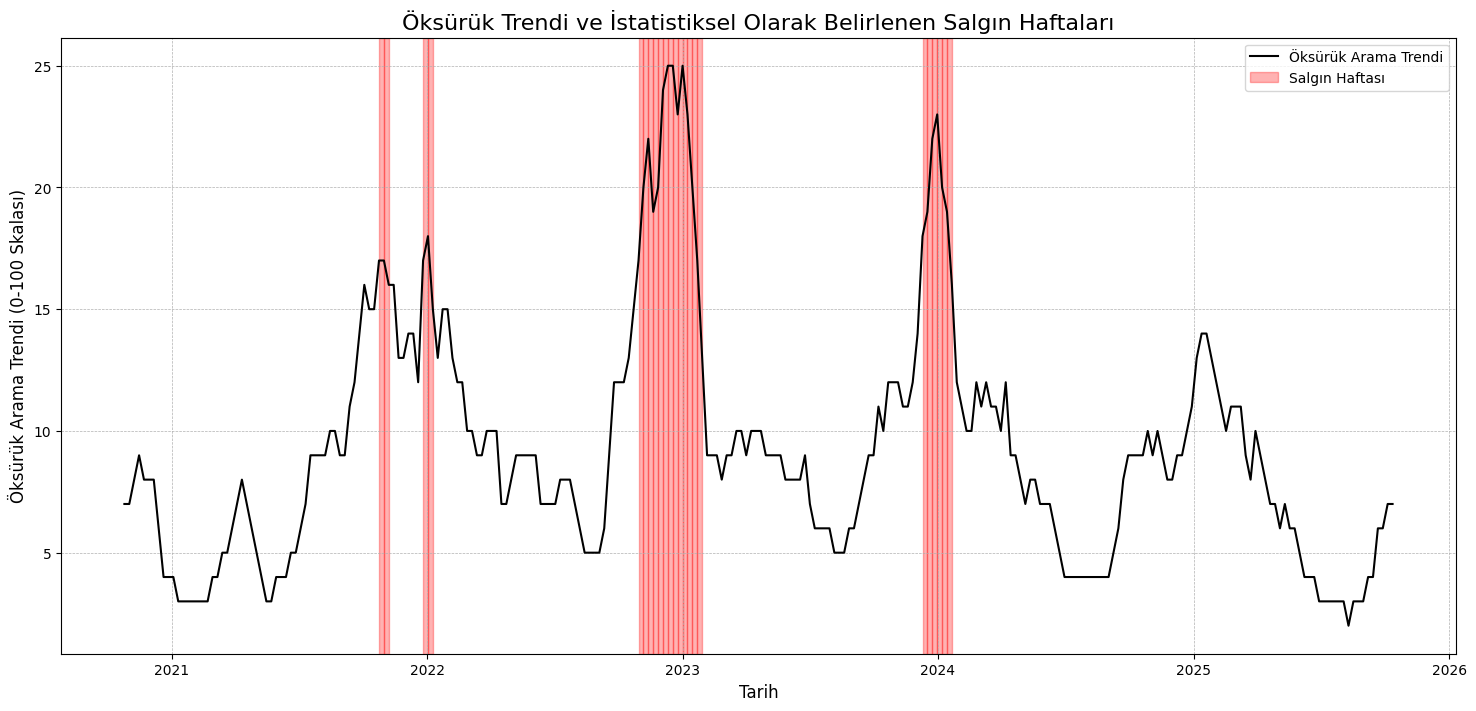

In [137]:
# Grafik için veri setimizi hazırlıyoruz
df_to_plot = df_labeled.copy()

# Salgın olarak etiketlediğimiz haftaları buluyoruz
salgin_haftalari = df_to_plot[df_to_plot['salgin_durumu'] == 1]

# Grafiğimizi oluşturuyoruz
fig, ax = plt.subplots(figsize=(18, 8))

# 'öksürük' arama trendinin tamamını çiziyoruz
ax.plot(df_to_plot.index, df_to_plot['öksürük'], color='black', label='Öksürük Arama Trendi', zorder=2)

# Salgın olan her hafta için arka planı kırmızıya boyuyoruz
for i, hafta in enumerate(salgin_haftalari.index):
    # Her salgın haftasının başlangıcından bitişine (7 gün sonrasına) kadar olan alanı boyuyoruz.
    ax.axvspan(hafta, hafta + pd.Timedelta(days=7), color='red', alpha=0.3, zorder=1,
               label='Salgın Haftası' if i == 0 else "")

ax.set_title('Öksürük Trendi ve İstatistiksel Olarak Belirlenen Salgın Haftaları', fontsize=16)
ax.set_ylabel('Öksürük Arama Trendi (0-100 Skalası)', fontsize=12)
ax.set_xlabel('Tarih', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper right')

plt.show()

### Hedef Değişken ve Özelliklerin Oluşturulması (Feature Engineering)

Sınıflandırma modelimizin temel amacı, mevcut haftanın verilerine bakarak **gelecek haftanın** bir "salgın haftası" olup olmayacağını öngörmektir. Bu "geleceğe bakma" yeteneğini modelimize kazandırmak için, veri setimizi hedef değişken (tahmin edilecek şey) ve özellikler (tahmin için kullanılacak bilgiler) olarak dikkatlice yapılandırmamız gerekir.

* **Hedef Değişken (y):** Tahmin etmek istediğimiz şey `gelecek haftanın salgın durumu` olduğu için, `salgin_durumu` sütunu bir hafta "öne" kaydırılarak (`shift(-1)`) hedef değişkenimiz oluşturulmuştur. Böylece her bir satırda, o haftanın özellikleri ile bir sonraki haftanın sonucu yan yana gelmiştir.
* **Özellikler (X):** Modelin tahmin yapmak için kullanacağı bilgiler şunlardır:
    * `öksürük`: Güncel haftanın arama hacmi.
    * `temperature_2m_mean`: Güncel haftanın ortalama sıcaklığı.
    * `oksuruk_lag_1`: **Bir önceki haftanın** öksürük arama hacmi. Bu "gecikmeli özellik" (lag feature), modele sadece o anki durumu değil, aynı zamanda trendin yönü (artışta mı, azalışta mı?) hakkında da bilgi vererek modelin hafızasını güçlendirir.

Aşağıdaki kod, bu özellikleri ve hedef değişkeni oluşturup, kaydırma işlemlerinden kaynaklanan eksik verili satırları temizleyerek modellemeye hazır nihai veri setini hazırlamaktadır.

In [140]:
# Ana veri setinin modellemeye özel bir kopyasını oluşturuyoruz
df_model = df_labeled.copy()

# 1. HEDEF (y) OLUŞTURMA: Gelecek haftanın salgın durumunu tahmin edeceğimiz için
# salgin_durumu sütununu bir hafta yukarı kaydırıyoruz.
df_model['hedef_salgin_gelecek_hafta'] = df_model['salgin_durumu'].shift(-1)

# 2. ÖZELLİKLER (X) OLUŞTURMA:
# Modele güncel haftanın bilgilerini veriyoruz.
X = df_model[['öksürük', 'temperature_2m_mean']].copy()
y = df_model['hedef_salgin_gelecek_hafta']

# Modele daha fazla bağlam vermek için bir önceki haftanın öksürük verisini de ekliyoruz
X['oksuruk_lag_1'] = X['öksürük'].shift(1)

# 3. TEMİZLİK: shift() işlemleri nedeniyle oluşan boş (NaN) satırları temizliyoruz.
final_df = pd.concat([X, y], axis=1).dropna()

X = final_df[['öksürük', 'temperature_2m_mean', 'oksuruk_lag_1']]
y = final_df['hedef_salgin_gelecek_hafta']

print("--- Model İçin Hazırlanan Özellikler (X) ---")
print(X.head())
print("\n--- Model İçin Hazırlanan Hedef (y) ---")
print(y.head())

--- Model İçin Hazırlanan Özellikler (X) ---
            öksürük  temperature_2m_mean  oksuruk_lag_1
Hafta                                                  
2020-11-01        7            13.857143            7.0
2020-11-08        8             8.842857            7.0
2020-11-15        9             7.385714            8.0
2020-11-22        8             5.142857            9.0
2020-11-29        8             1.871429            8.0

--- Model İçin Hazırlanan Hedef (y) ---
Hafta
2020-11-01    0.0
2020-11-08    0.0
2020-11-15    0.0
2020-11-22    0.0
2020-11-29    0.0
Name: hedef_salgin_gelecek_hafta, dtype: float64




--- Model Performans Raporu ---
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97        71
         1.0       0.67      0.86      0.75         7

    accuracy                           0.95        78
   macro avg       0.83      0.91      0.86        78
weighted avg       0.96      0.95      0.95        78


--- Karmaşıklık Matrisi (Confusion Matrix) ---


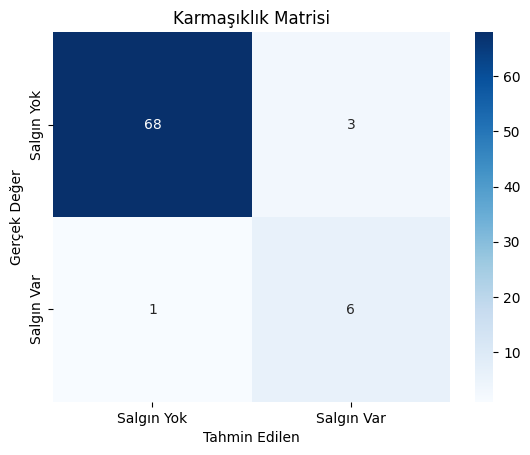

In [141]:
# Veriyi %70 eğitim, %30 test olarak ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Lojistik Regresyon modelini oluşturuyoruz
model = LogisticRegression(random_state=42)

# Modeli eğitim verisiyle eğitiyoruz
model.fit(X_train, y_train)

# Modelin test verisi üzerindeki tahminlerini yapıyoruz
y_pred = model.predict(X_test)

# Modelin performansını değerlendiriyoruz
print("\n\n--- Model Performans Raporu ---")
print(classification_report(y_test, y_pred))

print("\n--- Karmaşıklık Matrisi (Confusion Matrix) ---")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Salgın Yok', 'Salgın Var'], yticklabels=['Salgın Yok', 'Salgın Var'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Karmaşıklık Matrisi')
plt.show()

###Model Performansının Değerlendirilmesi ve Yorumlanması

Kurulan Lojistik Regresyon modeli, daha önce hiç görmediği test verileri üzerinde bir "erken uyarı sistemi" prototipi için oldukça başarılı ve umut verici sonuçlar ortaya koymuştur. Modelin performansı, hem Karmaşıklık Matrisi (Confusion Matrix) hem de Sınıflandırma Raporu (Classification Report) ile detaylıca incelenmiştir.

#### Karmaşıklık Matrisinin Yorumu:
Matris, modelimizin dört temel senaryodaki başarısını göstermektedir:
* **Doğru Pozitif (6):** Model, gerçekte "Salgın Olan" 7 haftanın 6'sını doğru bir şekilde **tespit etmiştir.** Bu, sistemin salgınları yakalama konusundaki ana başarısını gösterir.
* **Yanlış Negatif (1):** Model, gerçekte "Salgın Olan" **sadece 1 haftayı gözden kaçırmıştır.** Bir erken uyarı sistemi için en kritik hata olan bu durumun sayısının bu kadar düşük olması, modelin en güçlü yanıdır.
* **Yanlış Pozitif (3):** Model, **3 kez** "Salgın Var" diyerek **yanlış alarm** vermiştir. Bu, sistemin hassasiyetinin kabul edilebilir bir yan etkisidir.
* **Doğru Negatif (68):** Normal geçen 71 haftanın 68'ini doğru sınıflandırarak gereksiz panik yaratma potansiyelinin düşük olduğunu göstermiştir.

#### Sınıflandırma Raporunun Yorumu:
Rapordaki en kritik metrikler, "Salgın Var" (etiketi `1.0` olan sınıf) için şunlardır:
* **Recall (Duyarlılık): 0.86** - Bu metrik, gerçek salgın haftalarının **%86'sını** başarıyla yakalayabildiğimizi gösterir. Bir erken uyarı sisteminin asıl amacı salgınları kaçırmamak olduğu için, bu yüksek `recall` değeri projenin en önemli başarı göstergesidir.
* **Precision (Kesinlik): 0.67** - Bu metrik, modelimiz bir hafta için "Salgın Riski Var" dediğinde, bu tahminin **%67** ihtimalle doğru olduğunu belirtir. Yani, sistemin verdiği her 3 alarmdan yaklaşık 2'si gerçekten dikkate alınması gereken bir durumu işaret etmektedir.

#### Nihai Değerlendirme:
Sonuç olarak, kurulan model, salgınları yüksek bir duyarlılıkla (%86) tespit edebilen ve verdiği alarmların da büyük oranda (%67) isabetli olduğu, **etkili bir erken uyarı sistemi prototipi** olarak değerlendirilebilir.